# AAut lab question 2 part 1

## Image classification

# Initial steps
Import libraries

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from imblearn.over_sampling import SMOTE

Load data

In [15]:
Xtest1 = np.load('Xtest1.npy')
Xtrain1 = np.load('Xtrain1.npy')
Xtrain1_extra = np.load('Xtrain1_extra.npy')
Ytrain1 = np.load('Ytrain1.npy')
Ytrain1_extra = np.load('Ytrain1_extra.npy')

Compute SMOTE (Synthetic Minority Over-sampling Technique) to deal with the low quantity of crater data

In [16]:
smote = SMOTE()
Xtrain_resampled, Ytrain_resampled = smote.fit_resample(Xtrain1, Ytrain1)

Xtrain_resampled = Xtrain_resampled.reshape(-1, 48, 48, 1)

Split data into train and test

In [17]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(Xtrain_resampled, Ytrain_resampled, test_size=0.2, random_state=42)

# Convert labels to categorical (binary classification)
y_train_cat = to_categorical(y_train, 2)
y_val_cat = to_categorical(y_val, 2)

Data augmentation

In [18]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

## Build CNNs

### CNN

In [19]:
# Build a simple CNN model
model_CNN = Sequential([
    Input(shape=(48, 48, 1)),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

### VGG16

In [20]:
# Load VGG16 model with pre-trained weights, excluding the top layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze the layers of VGG16
for layer in vgg16_base.layers:
    layer.trainable = False

# Add custom layers on top of VGG16
vgg16_model = Sequential([
    Input(shape=(48, 48, 1)),
    Conv2D(3, (1, 1), activation='relu'),  # Convert grayscale to RGB
    vgg16_base,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

### ResNet50

In [21]:
# Load ResNet50 model with pre-trained weights, excluding the top layers
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze the layers of ResNet50
for layer in resnet_base.layers:
    layer.trainable = False

# Add custom layers on top of ResNet50
resnet_model = Sequential([
    Input(shape=(48, 48, 1)),
    Conv2D(3, (1, 1), activation='relu'),  # Convert grayscale to RGB
    resnet_base,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

## Train the models

Callbacks

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-5)

### CNN

In [23]:
# Compile the model
model_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_CNN = model_CNN.fit(datagen.flow(X_train, y_train_cat), validation_data=(X_train, y_train_cat), epochs=20, callbacks=[early_stopping, reduce_lr], batch_size=32)

Epoch 1/20
 1/63 ━━━━━━━━━━━━━━━━━━━━ 2:59 3s/step - accuracy: 0.4688 - loss: 1.7108

c:\Users\tomas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.6338 - loss: 1.5196 - val_accuracy: 0.4980 - val_loss: 10.3784 - learning_rate: 0.0010
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7682 - loss: 0.5940 - val_accuracy: 0.4975 - val_loss: 3.0101 - learning_rate: 0.0010
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7801 - loss: 0.5391 - val_accuracy: 0.5166 - val_loss: 2.2395 - learning_rate: 0.0010
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7842 - loss: 0.4789 - val_accuracy: 0.7603 - val_loss: 0.5584 - learning_rate: 0.0010
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8287 - loss: 0.4163 - val_accuracy: 0.6402 - val_loss: 1.2392 - learning_rate: 0.0010
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8121 - loss: 0.4484 - val_accuracy: 0.5834 - val_loss: 1.7629 - learning_rate: 0.0010
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8069 - loss: 0.4275 - val_accuracy: 0.7

### VGG16


In [24]:
vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the VGG16 model with data augmentation
history_vgg16 = vgg16_model.fit(datagen.flow(X_train, y_train_cat), 
                                validation_data=(X_val, y_val_cat), 
                                epochs=20, 
                                callbacks=[early_stopping, reduce_lr], batch_size=32)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 275ms/step - accuracy: 0.6549 - loss: 7.6051 - val_accuracy: 0.8815 - val_loss: 1.3299 - learning_rate: 0.0010
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 264ms/step - accuracy: 0.7926 - loss: 2.7682 - val_accuracy: 0.8614 - val_loss: 0.9110 - learning_rate: 0.0010
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 269ms/step - accuracy: 0.8049 - loss: 1.4234 - val_accuracy: 0.8795 - val_loss: 0.6324 - learning_rate: 0.0010
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 281ms/step - accuracy: 0.8101 - loss: 0.8653 - val_accuracy: 0.8735 - val_loss: 0.6022 - learning_rate: 0.0010
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 279ms/step - accuracy: 0.8247 - loss: 0.6741 - val_accuracy: 0.8876 - val_loss: 0.3901 - learning_rate: 0.0010
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 254ms/step - accuracy: 0.8262 - loss: 0.5674 - val_accuracy: 0.8876 - val_loss: 0.3180 - learning_rate: 0.0010
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 264ms/step - accuracy: 0.8424 - loss: 0.

### ResNet50

In [25]:
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the ResNet50 model with data augmentation
history_resnet = resnet_model.fit(datagen.flow(X_train, y_train_cat), 
                                  validation_data=(X_val, y_val_cat), 
                                  epochs=20, 
                                  callbacks=[early_stopping, reduce_lr], batch_size=32)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 222ms/step - accuracy: 0.7608 - loss: 0.8346 - val_accuracy: 0.8715 - val_loss: 0.2981 - learning_rate: 0.0010
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 0.8557 - loss: 0.3527 - val_accuracy: 0.9076 - val_loss: 0.2658 - learning_rate: 0.0010
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 245ms/step - accuracy: 0.8636 - loss: 0.2967 - val_accuracy: 0.9036 - val_loss: 0.2596 - learning_rate: 0.0010
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 270ms/step - accuracy: 0.8838 - loss: 0.2815 - val_accuracy: 0.8876 - val_loss: 0.2596 - learning_rate: 0.0010
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - accuracy: 0.8789 - loss: 0.2716 - val_accuracy: 0.9056 - val_loss: 0.2442 - learning_rate: 0.0010
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 269ms/step - accuracy: 0.8724 - loss: 0.3063 - val_accuracy: 0.8936 - val_loss: 0.2571 - learning_rate: 0.0010
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 272ms/step - accuracy: 0.8791 - loss: 0.

## Evaluation of the models

### CNN

In [26]:
# Evaluate the model on the validation set
y_val_pred_CNN = model_CNN.predict(X_val)
y_val_pred_classes_CNN = np.argmax(y_val_pred_CNN, axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


### VGG16

In [27]:
# Evaluate the VGG16 model on the validation set
y_val_pred_vgg16 = vgg16_model.predict(X_val)
y_val_pred_classes_vgg16 = np.argmax(y_val_pred_vgg16, axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step


### ResNet50

In [28]:
# Evaluate the ResNet50 model on the validation set
y_val_pred_resnet = resnet_model.predict(X_val)
y_val_pred_classes_resnet = np.argmax(y_val_pred_resnet, axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step


In [29]:
# Calculate F1 Score
f1_CNN = f1_score(y_val, y_val_pred_classes_CNN)
f1_vgg16 = f1_score(y_val, y_val_pred_classes_vgg16)
f1_resnet = f1_score(y_val, y_val_pred_classes_resnet)
print(f"Validation F1 Score: {f1_CNN} (CNN), {f1_vgg16} (VGG16), {f1_resnet} (ResNet50)")

Validation F1 Score: 0.6971153846153846 (CNN), 0.8987341772151899 (VGG16), 0.8969957081545065 (ResNet50)


training history

In [30]:
# Plot training history (optional)
def plot_history(history):
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

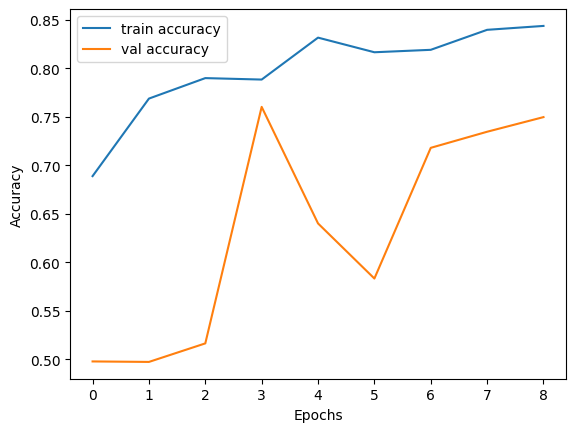

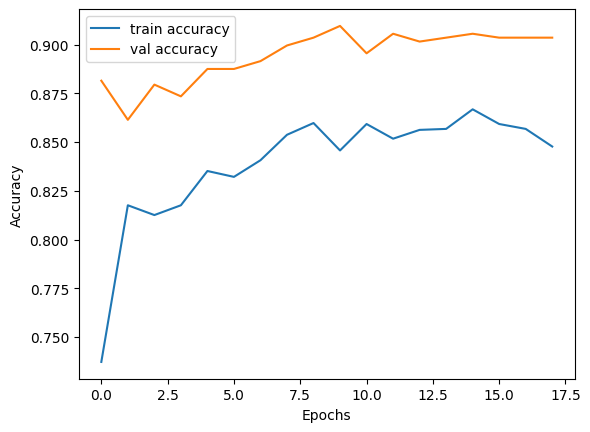

In [31]:

plot_history(history_CNN)
plot_history(history_vgg16)